In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils

pd.options.mode.chained_assignment = None

In [76]:
df = utils.load_backtest_data()
display(df.head())
df.shape

,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Acquiror Name,Exchange Ratio,Price Per Share,Acquiror's price per share,Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Success,Predicted
2485,2019-01-02,2019-05-17,NaT,3330497020,MedEquities Realty Trust Inc,Omega Healthcare Investors Inc,0.235,10.26,35.15,6.84,10.00,10.59,11.04,NaN,1,1
2487,2019-01-03,2019-11-20,NaT,3330372020,Celgene Corp,Bristol-Myers Squibb Co,1.000,102.43,52.43,66.64,84.90,85.74,93.85,93.88,1,1
2489,2019-01-07,2019-07-29,NaT,3331582020,HopFed Bancorp Inc,First Financial Corp,NaN,21.00,NaN,14.24,18.66,19.89,19.98,19.68,1,1
2492,2019-01-08,2019-10-25,NaT,3405759020,Isramco Inc,Naphtha Israel Petro Corp Ltd,NaN,121.40,NaN,121.38,NaN,103.01,119.29,123.30,1,1
2494,2019-01-14,NaT,2019-11-19,3333563020,Gannett Co Inc,MediaNews Group Inc,NaN,12.00,NaN,9.75,11.82,10.90,10.10,8.14,0,0


(302, 16)

In [77]:
class Backtester:
    def __init__(self, data: pd.DataFrame):
        self.dummy_mode = False
        self.data = data
        self.cutoff_days = 180
        self.cutoff_column = f"Target Closing Price {self.cutoff_days} Days After Ann Date ($)"
        self.successes = None
        self.failure = None
        self.combined = None

    def set_dummy_mode(self, mode: bool) -> 'Backtester':
        self.dummy_mode = mode
        return self

    def set_cutoff_days(self, days: int) -> 'Backtester':
        '''
        Sets cutoff number of days to close the position if deal has not been completed yet
        days: int
            - options: 60, 90, 180
        '''
        if days not in (60, 90, 180):
            raise Exception(f"{days} not valid, options: 60, 90, 180")
        self.cutoff_days = days
        self.cutoff_column = f"Target Closing Price {days} Days After Ann Date ($)"
        return self

    def start(self) -> 'Backtester':
        '''
        Runs backtest
        '''
        df = self.data.copy()
        if self.dummy_mode:
            # predict all true
            longs = df
        else:
            longs = df[df["Predicted"] == 1]

        # if it takes longer than self.cutoff_days to complete the merger, close the position early 
        longs["Success"] = np.where((longs["Success"] == 1) & (longs["Date Announced"] + pd.Timedelta(days=self.cutoff_days) < longs["Date Effective"]), 0, 1)
        
        # only trade where premium is positive
        longs = longs[longs["Price Per Share"] > longs["Target Closing Price 1 Day After Ann Date ($)"]] 

        successes = longs[longs["Success"] == 1] 
        failures =  longs[longs["Success"] == 0]

        successes["Holding Time"] = (successes["Date Effective"] - successes["Date Announced"]).dt.days / 252
        failures["Holding Time"] = self.cutoff_days / 252

        successes["Pct Return"] = ( successes["Price Per Share"] / successes["Target Closing Price 1 Day After Ann Date ($)"] ) ** successes["Holding Time"] - 1
        failures["Pct Return"] =  ( failures[self.cutoff_column] / failures["Target Closing Price 1 Day After Ann Date ($)"] ) ** failures["Holding Time"] - 1
        failures = failures.dropna(subset="Pct Return")        

        # remove anomalous data
        
        lower_q = 0.05
        upper_q = 0.95

        lower = successes["Pct Return"].quantile(lower_q)
        upper = successes["Pct Return"].quantile(upper_q)
        successes = successes[(successes["Pct Return"] < upper) & (successes["Pct Return"] > lower)]
        
        lower = failures["Pct Return"].quantile(lower_q)
        upper = failures["Pct Return"].quantile(upper_q)
        failures = failures[(failures["Pct Return"] < upper) & (failures["Pct Return"] > lower)]
        
        # send to fields
        self.successes = successes
        self.failures = failures
        self.combined = pd.concat([successes, failures], axis=0)
        
        return self
    
    def get_results(self) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        return self.successes, self.failures, self.combined

## Backtest Strategy

In [78]:
# global settings
CUTOFF_DAYS = 60

In [79]:
backtest = Backtester(df)
backtest.set_cutoff_days(CUTOFF_DAYS)
backtest.start()
successes, failures, combined = backtest.get_results()

In [80]:
combined.shape

(173, 18)

In [81]:
def get_mean_returns(successes, failures, combined):
    success_mean = successes["Pct Return"].mean()
    failure_mean = failures["Pct Return"].mean()
    combined_mean = combined["Pct Return"].mean()
    return success_mean, failure_mean, combined_mean

success_mean, failure_mean, combined_mean = get_mean_returns(successes, failures, combined)
print("Model Performance:")
print(f"Success mean Return: {round(success_mean,5)}")
print(f"Failure mean Return: {round(failure_mean,5)}")
print(f"Combined mean Return: {round(combined_mean,5)}")

Model Performance:
Success mean Return: 0.02239
Failure mean Return: 0.00358
Combined mean Return: 0.00532


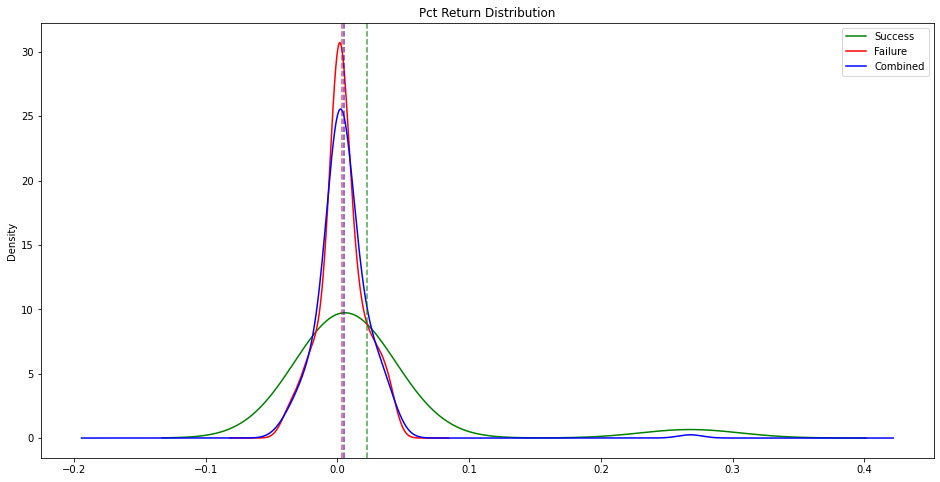

In [82]:
def plot_return_distribution(successes, failures, combined):
    successes["Pct Return"].plot(kind="kde", label="Success", color="green",figsize=(16,8))
    failures["Pct Return"].plot(kind="kde", label="Failure", color="red")
    combined["Pct Return"].plot(kind="kde", label="Combined", color="blue")

    success_mean, failure_mean, combined_mean = get_mean_returns(successes, failures, combined)
    plt.axvline(success_mean, color="green", linestyle="--", alpha=0.7)
    plt.axvline(failure_mean, color="red", linestyle="--", alpha=0.7)
    plt.axvline(combined_mean, color="blue", linestyle="--", alpha=0.7)
    plt.title("Pct Return Distribution")
    plt.legend()
    plt.show()

plot_return_distribution(successes, failures, combined)

## Compare against dummy strategy (buy all mergers)

In [83]:
backtest = Backtester(df).set_dummy_mode(True)
backtest.set_cutoff_days(CUTOFF_DAYS)
backtest.start()
successes, failures, combined = backtest.get_results()

In [84]:
success_mean, failure_mean, combined_mean = get_mean_returns(successes, failures, combined)
print("Dummy Performance:")
print(f"Success mean Return: {round(success_mean,5)}")
print(f"Failure mean Return: {round(failure_mean,5)}")
print(f"Combined mean Return: {round(combined_mean,5)}")

Dummy Performance:
Success mean Return: 0.01997
Failure mean Return: 0.00331
Combined mean Return: 0.00495


In [85]:
combined.shape

(183, 18)

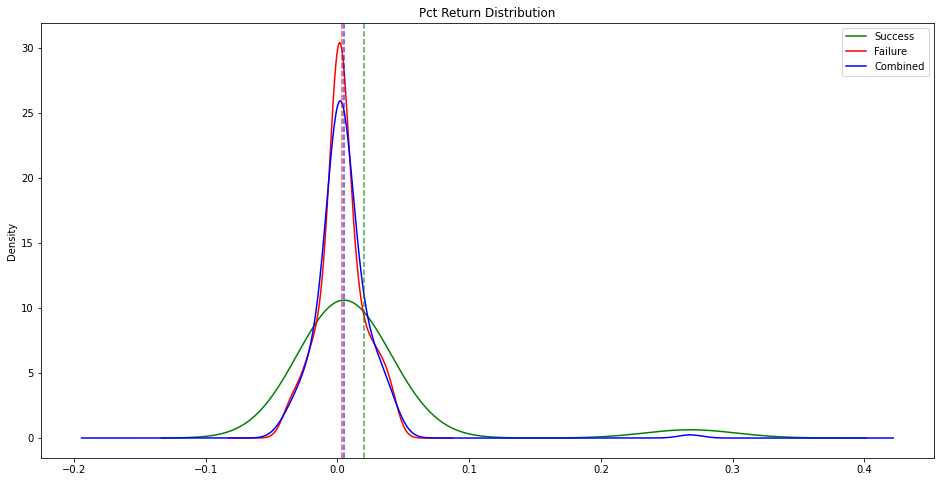

In [86]:
plot_return_distribution(successes, failures, combined)

## Conclusions
- Even with the ability to detect false positives better, the market is already very efficient at pricing mergers
- There is very marginal improvement from using our model against a "long all mergers" strategy